# Advanced manual
This notebook shows some methods to make the customized target generator in more advaned ways. 

First, run the following lines.

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/e/workspace/project_quant/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/e/workspace/project_quant
changed directory is :  /mnt/e/workspace/project_quant


In [34]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

from benchmark_strategy.sap_only import Sap_onlyWeightGenerator

### Broad Market ETF
|Ticker|Name|Inception|list_name|
|-----|----------------------------|---------|-------------|
|SPY|SPDR S&P 500 ETF Trust |1993-01-22|yfinance_list| 
|EFA|iShares MSCI EAFE ETF |2001-08-14|yfinance_list|
|EEM|iShares MSCI Emerging Markets ETF |2003-04-07|yfinance_list|
|AGG|iShares Core U.S. Aggregate Bond ETF |2003-09-22|yfinance_list|   

### Equity Sector ETF
|Ticker|Name|Inception|list_name|
|-----|----------------------------|---------|-------------|
|XLC|Communication Services Select Sector SPDR Fund|2018-06-18|yfinance_list| 
|XLY|Consumer Discretionary Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLP|Consumer Staples Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLE|Energy Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLF|Financial Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLV|Health Care Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLI|Industrial Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLB|Materials Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLK|Technology Select Sector SPDR Fund|1998-12-16|yfinance_list| 
|XLU|Utilities Select Sector SPDR Fund|1998-12-16|yfinance_list|   

### Fixed Income ETF
|Ticker|Name|Inception|list_name|
|-----|----------------------------|---------|-------------|
|SHY|iShares 1-3 Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|IEF|iShares 7-10 Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|TLH|iShares 10-20 Year Treasury Bond ETF|2007-01-05|yfinance_list| 
|TLT|iShares 20+ Year Treasury Bond ETF|2002-07-22|yfinance_list| 
|AGG|iShares Core U.S. Aggregate Bond ETF|2003-09-22|yfinance_list| 
|LQD|iShares iBoxx Investment Grade Corporate Bond ETF|2002-07-22|yfinance_list| 
|HYG|iShares iBoxx High Yield Corporate Bond ETF|2007-04-04|yfinance_list| 
|TIP|iShares TIPS Bond ETF|2003-12-04|yfinance_list| 
|MBB|iShares MBS ETF|2007-03-13|yfinance_list| 
|EMB|iShares J.P. Morgan USD Emerging Markets Bond ETF|2007-12-17|yfinance_list|  

### Alternative Asset Class ETF
|Ticker|Name|Inception|list_name|
|-----|----------------------------|---------|-------------|
|VNQ|Vanguard Real Estate Index Fund|2004-09-23|yfinance_list| 
|GLD|SPDR Gold Shares|2004-11-18|yfinance_list| 
|IGF|iShares Global Infrastructure ETF|2007-12-10|yfinance_list|  
|USO|United States Oil Fund, LP|2006-04-10|yfinance_list| 
|UUP|Invesco DB US Dollar Index Bullish Fund|2007-07-20|yfinance_list|   


### Daily Market Index from FRED
|Ticker|Name|Inception|list_name|
|-----|----------------------------|---------|-------------|
 BAMLH0A0HYM2|ICE BofA US High Yield Index Option-Adjusted Spread|1996-12-31|market_fred_list|
|BAMLC0A4CBBB|ICE BofA BBB US Corporate Index Option-Adjusted Spread|1996-12-31|market_fred_list|
|BAMLH0A3HYC|ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread|1996-12-31|market_fred_list|
|T10Y2Y|10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity|1976-06-01|market_fred_list|
|T10YIE|10-Year Breakeven Inflation Rate|2003-01-02|market_fred_list|
|T5YIE|5-Year Breakeven Inflation Rate|2003-01-02|market_fred_list|  

### Periodic Macro Index from FRED
|Ticker|Name|Inception|list_name|
|-----|----------------------------|---------|-------------|
|CSUSHPINSA|S&P/Case-Shiller U.S. National Home Price Index|1987-01-01|fred_list|
|UMCSENT|University of Michigan: Consumer Sentiment|1952-11-01|fred_list|
|CPIAUCSL|Consumer Price Index for All Urban Consumers: All Items in U.S. City Average|1947-01-01|fred_list|
|PCE|Personal Consumption Expenditures|1959-01-01|fred_list|
|M2SL|M2|1959-01-01|fred_list|
|ICSA|Initial Claims|1967-01-07|fred_list|

In [35]:
# You can add tickers if you need

# macro data can be added by fred_list arg
print("available macro data : " ,engine.cache['macro'].keys())

# index data can be added by yfinance_list arg
print("available index data : " ,engine.cache['index'].keys())

# index data can be added by market_fred_list arg
print("available market data : " ,engine.cache['market'].keys())

available macro data :  dict_keys(['CPIAUCSL'])
available index data :  dict_keys(['SPY', 'XLP', 'XLF', 'XLE', 'XLB', 'XLV', 'XLK', 'XLU', 'XLI', 'XLY'])
available market data :  dict_keys(['BAMLH0A0HYM2'])


### CPI-based momentum/volatility rotation strategy
The following class allocates the weight according to inflation sign (CPI YoY). If CPI_YoY > 0, the weights are allocated on momentum ETFs. If CPI_YoY < 0, the weights are allocated on low-volatility ETFs.

In [36]:
class MomentumWeightGenerator(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)

    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        target_weight = {}

        momentum_zscore = self.compute_factor_zscore(universe_list=universe_list, ftype='momentum')
        invVol_zscore = self.compute_factor_zscore(universe_list=universe_list, ftype='invVol')      

        CPI = self.get_value(ticker='CPIAUCSL', table='macro', value='value', lag=0)
        CPI_12M = self.get_value(ticker='CPIAUCSL', table='macro', value='value', lag=12)
        CPI_chg_YoY = np.log(float(CPI)/float(CPI_12M))
        """
        get_value method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : 'openadj', 'highadj', 'lowadj', 'closeadj' for 'index' table and 'value' for 'macro' table
            lag : number of lagged data points (lag=0 gives the point-in-time latest availabe data)
            float
        """

        if CPI_chg_YoY > 0 :
            for ticker in universe_list:
                if ticker in momentum_zscore.index and momentum_zscore[ticker] > 0:
                    target_weight[ticker] = momentum_zscore[ticker]
        else:
            for ticker in universe_list:
                if ticker in invVol_zscore.index and invVol_zscore[ticker] > 0:
                    target_weight[ticker] = invVol_zscore[ticker]

        target_weight = self.normalize(target_weight)

        return target_weight

    def compute_factor_zscore(self, universe_list, ftype):
        """
        compute_factor_zscore method
        Inputs
            universe_list(list)
            ftype(str)
        Outputs
            pd.Series
        """  
        ticker_to_factor = {}
        for ticker in universe_list:
            try:
                factor = self.compute_factor(ticker, ftype)
            except:
                factor = np.nan
            if np.isnan(factor):
                pass
            else:
                ticker_to_factor[ticker] = factor
        factor_series = pd.Series(ticker_to_factor).dropna().sort_values(ascending=False)
        factor_series = (factor_series-factor_series.mean())/factor_series.std()
        
        return factor_series  

    def compute_factor(self, ticker, ftype):
        """
        Inputs
            ticker(str) : name of ETF
            ftype(str) : name of factor
        Outputs
            float
        """
        try:
            if ftype == 'momentum':
                return self.momentum_factor(ticker=ticker)
            
            elif ftype == 'invVol':
                return self.inverse_vol_factor(ticker=ticker)
        except:
            return np.nan
        
            
    def momentum_factor(self, ticker):
        price = self.get_value(ticker=ticker, table='index', value='closeadj', lag=0) 
        price_12M = self.get_value(ticker=ticker, table='index', value='closeadj', lag=252) 
        """
        get_value method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : 'openadj', 'highadj', 'lowadj', 'closeadj' for 'index' table / 'value' for 'macro' and 'market' table
            lag : number of lagged data points (lag=0 gives the point-in-time latest availabe data)
            float
        """
        momentum = np.log(price/price_12M)
        return momentum
    
    def inverse_vol_factor(self, ticker):
        price_series = self.get_value_series(ticker=ticker, table='index', value='closeadj', lag=252)
        """
        get_value_series method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : open, high, low, close for 'index' table and value for 'macro' table
            lag : number of lagged data points
        Outputs
            pd.Series
        """
        vol = price_series.apply(np.log).diff().std()
        return 1/vol

In [37]:
# engine = BacktestEngine()
custom_universe = ['XLY', 'XLP', 'XLE' ,'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
mtg = MomentumWeightGenerator(engine.cache)
engine.run_backtest(target_generator=mtg, sdate='2010-01-01', edate='2021-01-01')

[__init__] is executed in 7.80 seconds
Backtest period: 2010-01-04 00:00:00 -- 2020-12-31 00:00:00
=== date:2020-12-31 00:00:00 / total_asset:3.083 / time elapsed:3.7 ===
[run_backtest] is executed in 3.85 seconds


In [38]:
bm_engine = BacktestEngine(yfinance_list=['SPY'])
sap_only = Sap_onlyWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=sap_only, sdate='2010-01-01', edate='2021-01-01')

[__init__] is executed in 3.06 seconds
Backtest period: 2010-01-04 00:00:00 -- 2020-12-31 00:00:00
=== date:2020-12-31 00:00:00 / total_asset:4.105 / time elapsed:1.2 ===
[run_backtest] is executed in 1.28 seconds


### Visualization
Now let us compare the performance of the strategy with S&P 500 index.

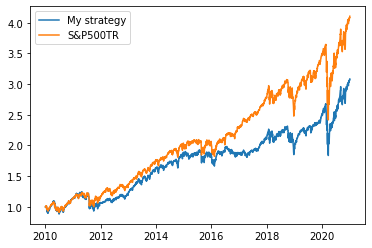

In [39]:
myasset = engine.asset_df.sum(axis=1)
benchmark = bm_engine.asset_df.sum(axis=1)

plt.plot(myasset)
plt.plot(benchmark)
plt.legend(['My strategy', 'S&P500TR'])

My strategy failed to beat the benchmark. Its time to make your own!

### View cache
You can view cache data as follows.

In [7]:
print(engine.cache['macro'].keys())
engine.cache['macro']['CPIAUCSL']
# datekey : date when the value is announced
# cdate : carlendar date
# is_inferred : whether the datekey is inferred from cdate or not 

dict_keys(['M2', 'ICSA', 'PCE', 'CPIAUCSL'])


,value,is_inferred,cdate,ticker
datekey,,,,
1947-02-16,21.48,True,1947-01-01,CPIAUCSL
1947-03-19,21.62,True,1947-02-01,CPIAUCSL
1947-04-16,22.0,True,1947-03-01,CPIAUCSL
1947-05-17,22.0,True,1947-04-01,CPIAUCSL
1947-06-16,21.95,True,1947-05-01,CPIAUCSL
...,...,...,...,...
2022-02-10,281.933,False,2022-01-01,CPIAUCSL
2022-03-10,284.182,False,2022-02-01,CPIAUCSL
2022-04-12,287.708,False,2022-03-01,CPIAUCSL


In [8]:
print(engine.cache['market'].keys())
engine.cache['market']['BAMLH0A0HYM2']
# datekey : date when the value is announced
# cdate : carlendar date
# is_inferred : whether the datekey is inferred from cdate or not 

dict_keys(['BAMLH0A0HYM2', 'T10Y2Y', 'T5YIE'])


,value,ticker
date,,
2000-01-03,4.68,BAMLH0A0HYM2
2000-01-04,4.81,BAMLH0A0HYM2
2000-01-05,4.77,BAMLH0A0HYM2
2000-01-06,4.82,BAMLH0A0HYM2
2000-01-07,4.86,BAMLH0A0HYM2
...,...,...
2019-12-26,3.53,BAMLH0A0HYM2
2019-12-27,3.56,BAMLH0A0HYM2
2019-12-30,3.60,BAMLH0A0HYM2


In [9]:
print(engine.cache['index'].keys())
engine.cache['index']['SPY']

dict_keys(['XLB', 'XLI', 'XLU', 'XLV', 'XLY', 'XLE', 'XLF', 'XLP', 'XLK', 'SPY'])


,openadj,highadj,lowadj,closeadj,volume,dividends,stock splits,ticker
date,,,,,,,,
1993-01-29,25.456172,25.456172,25.329525,25.438080,1003200,0.0,0.0,SPY
1993-02-01,25.456186,25.619019,25.456186,25.619019,480500,0.0,0.0,SPY
1993-02-02,25.600928,25.691390,25.546650,25.673298,201300,0.0,0.0,SPY
1993-02-03,25.709480,25.962776,25.691388,25.944683,529400,0.0,0.0,SPY
1993-02-04,26.035134,26.107504,25.745654,26.053226,531500,0.0,0.0,SPY
...,...,...,...,...,...,...,...,...
2022-06-28,390.230011,393.160004,380.529999,380.649994,86548900,0.0,0.0,SPY
2022-06-29,381.230011,382.269989,378.420013,380.339996,65676000,0.0,0.0,SPY
2022-06-30,376.239990,380.660004,372.559998,377.250000,112508300,0.0,0.0,SPY


In [10]:
engine.asset_df

,cash,XLY,XLB,XLK,XLI,XLF,SPY,XLU,XLP,XLE,XLV
2010-01-04,0.0,0.237483,0.357184,0.405334,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-05,0.0,0.238354,0.358338,0.404811,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-06,0.0,0.238670,0.364428,0.400282,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-07,0.0,0.240649,0.361593,0.398715,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2010-01-08,0.0,0.240570,0.366633,0.401327,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.0,0.786940,0.460807,1.223363,0.016633,0.0,0.331924,0.0,0.071741,0.0,0.154508
2020-12-28,0.0,0.795912,0.459004,1.237202,0.016654,0.0,0.334776,0.0,0.072311,0.0,0.154896
2020-12-29,0.0,0.796161,0.457910,1.231325,0.016553,0.0,0.334137,0.0,0.072096,0.0,0.155631
2020-12-30,0.0,0.800947,0.464219,1.230662,0.016659,0.0,0.334614,0.0,0.072021,0.0,0.155603


In [45]:
print(engine.cache['index'].keys())
a = engine.cache['index']
aa = pd.DataFrame(a['SPY']['closeadj'])
print(aa)

dict_keys(['SPY', 'XLP', 'XLF', 'XLE', 'XLB', 'XLV', 'XLK', 'XLU', 'XLI', 'XLY'])
              closeadj
date                  
1993-01-29   25.438089
1993-02-01   25.619028
1993-02-02   25.673292
1993-02-03   25.944698
1993-02-04   26.053242
...                ...
2022-06-28  380.649994
2022-06-29  380.339996
2022-06-30  377.250000
2022-07-01  381.239990
2022-07-05  381.959991

[7411 rows x 1 columns]


In [57]:
(engine.cache['index']['SPY'].index)


DatetimeIndex(['1993-01-29', '1993-02-01', '1993-02-02', '1993-02-03',
               '1993-02-04', '1993-02-05', '1993-02-08', '1993-02-09',
               '1993-02-10', '1993-02-11',
               ...
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24',
               '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30',
               '2022-07-01', '2022-07-05'],
              dtype='datetime64[ns]', name='date', length=7411, freq=None)